In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import platform
import numpy as np
import re

file_path = "/Users/a/Desktop/cursor/DataAnalysis/유저동향_요약결과_SQLite.xlsx"

period_df = pd.read_excel(file_path, sheet_name="1_기간별_게시글수")
region_df = pd.read_excel(file_path, sheet_name="2_지역별_비율")
neg_df = pd.read_excel(file_path, sheet_name="3_부정긍정비율")
source_df = pd.read_excel(file_path, sheet_name="4_출처비율")
market_df = pd.read_excel(file_path, sheet_name="7_공식포럼_긍부정비율")
neg_type_df = pd.read_excel(file_path, sheet_name="8_부정유형비율")

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
def extract_start_month(text):
    match = re.match(r"(\d+)월", str(text))
    return int(match.group(1)) if match else 0

for df in [period_df, region_df, neg_df, source_df]:
    df["month_order"] = df["동향 확인 기간"].apply(extract_start_month)
    df.sort_values(by="month_order", inplace=True)
    df.drop(columns=["month_order"], inplace=True)

## 기간별 게시글 수 추이

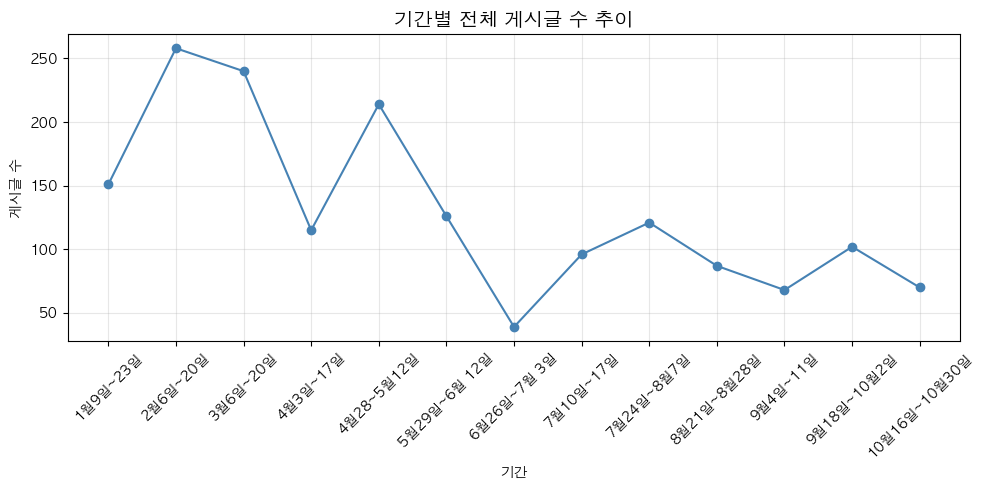

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(period_df["동향 확인 기간"], period_df["게시글 수"], marker="o", color="steelblue")
plt.title("기간별 전체 게시글 수 추이", fontsize=14, weight="bold")
plt.xlabel("기간")
plt.ylabel("게시글 수")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 기간별 국내/해외 비율

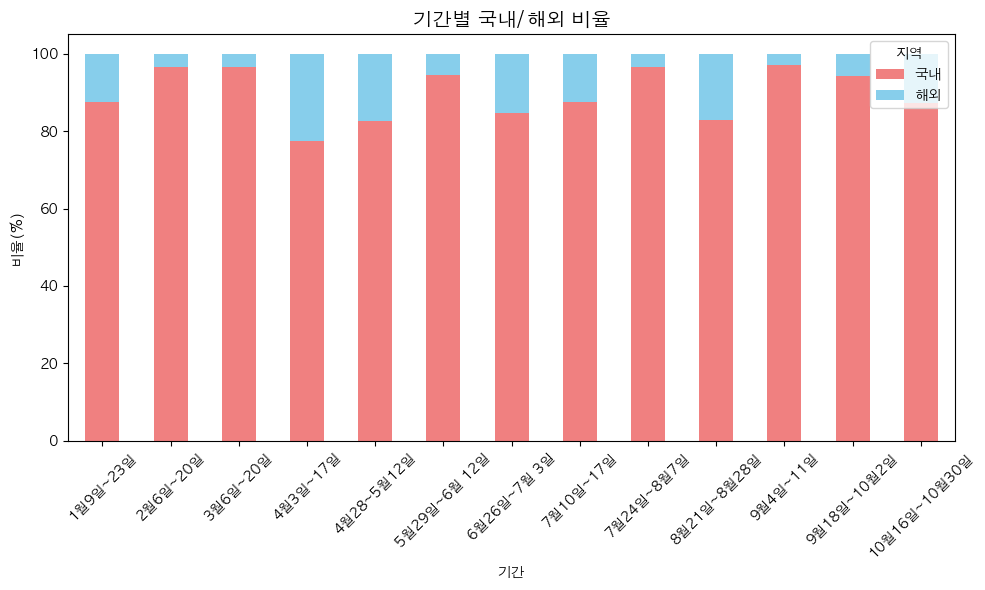

In [ ]:
region_df["월"] = region_df["동향 확인 기간"].apply(
    lambda x: int(re.search(r"(\d+)월", str(x)).group(1)) if re.search(r"(\d+)월", str(x)) else 0
)

region_df.sort_values("월", inplace=True)

ordered_periods = region_df["동향 확인 기간"].unique()
region_df["동향 확인 기간"] = pd.Categorical(region_df["동향 확인 기간"], categories=ordered_periods, ordered=True)

pivot_region = region_df.pivot(index="동향 확인 기간", columns="지역", values="비율(%)").fillna(0)

pivot_region.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=["lightcoral", "skyblue"]
)
plt.title("기간별 국내/해외 비율", fontsize=14, weight="bold")
plt.xlabel("기간")
plt.ylabel("비율(%)")
plt.xticks(rotation=45)
plt.legend(title="지역", loc="upper right")
plt.tight_layout()
plt.show()


## 부정/긍정 비율

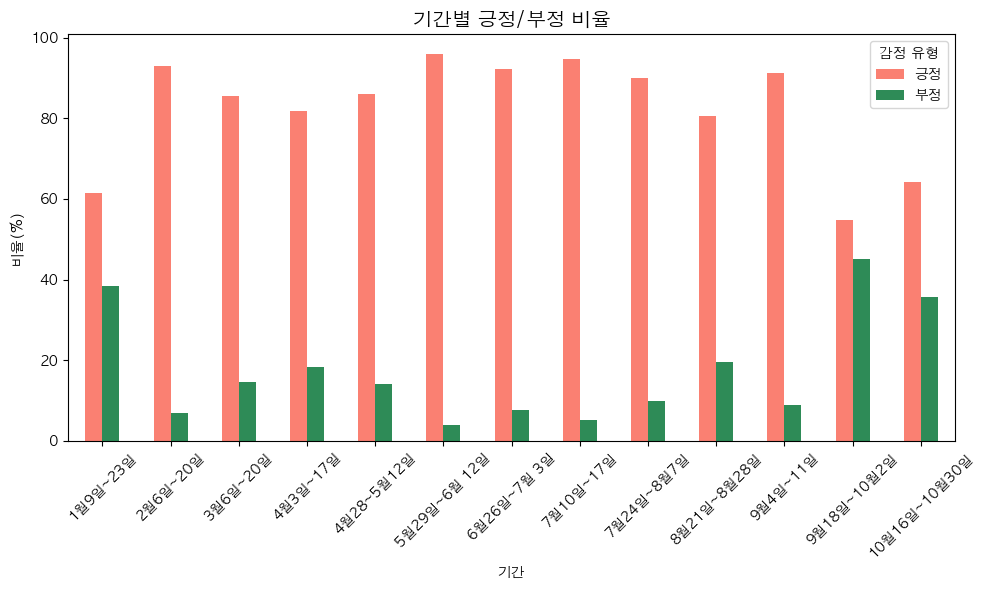

In [ ]:
neg_df["월"] = neg_df["동향 확인 기간"].apply(
    lambda x: int(re.search(r"(\d+)월", str(x)).group(1)) if re.search(r"(\d+)월", str(x)) else 0
)

neg_df.sort_values("월", inplace=True)

ordered_periods = neg_df["동향 확인 기간"].unique()
neg_df["동향 확인 기간"] = pd.Categorical(neg_df["동향 확인 기간"], categories=ordered_periods, ordered=True)

pivot_neg = neg_df.pivot(index="동향 확인 기간", columns="부정여부", values="비율(%)").fillna(0)

pivot_neg.plot(
    kind="bar",
    figsize=(10, 6),
    color=["salmon", "seagreen"]
)
plt.title("기간별 긍정/부정 비율", fontsize=14, weight="bold")
plt.xlabel("기간")
plt.ylabel("비율(%)")
plt.xticks(rotation=45)
plt.legend(title="감정 유형")
plt.tight_layout()
plt.show()

## 출처별 게시글 비율

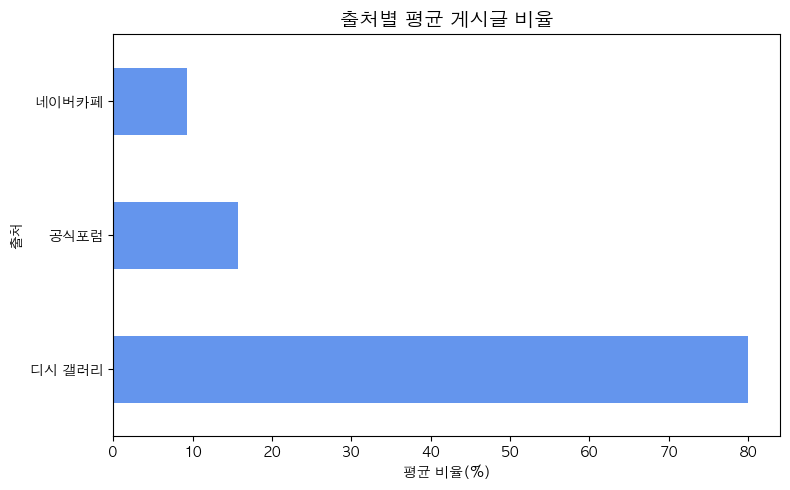

In [30]:
avg_source = source_df.groupby("출처")["비율(%)"].mean().sort_values(ascending=False)
avg_source.plot(kind="barh", figsize=(8, 5), color="cornflowerblue")
plt.title("출처별 평균 게시글 비율", fontsize=14, weight="bold")
plt.xlabel("평균 비율(%)")
plt.ylabel("출처")
plt.tight_layout()
plt.show()

## 기간별 부정률 변화 추이

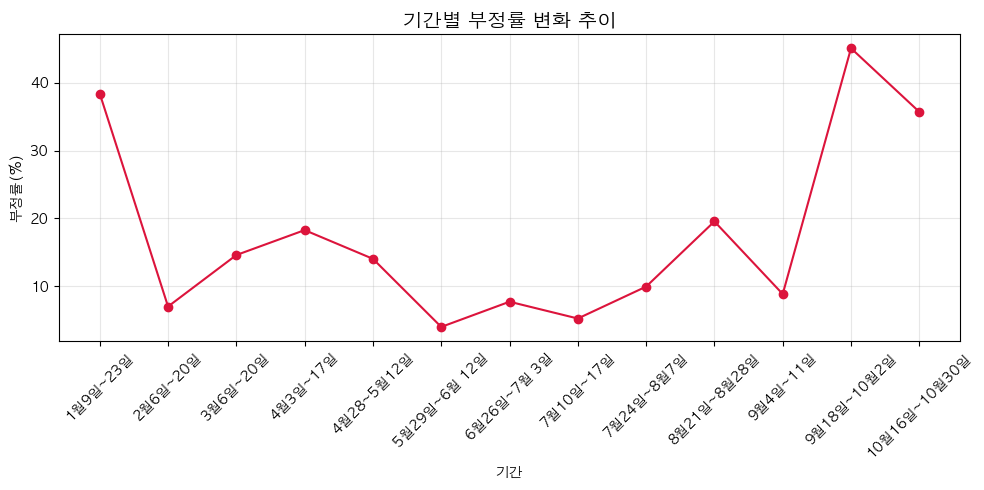

In [31]:
neg_trend = neg_df[neg_df["부정여부"] == "부정"]
plt.figure(figsize=(10, 5))
plt.plot(neg_trend["동향 확인 기간"], neg_trend["비율(%)"], marker="o", color="crimson")
plt.title("기간별 부정률 변화 추이", fontsize=14, weight="bold")
plt.xlabel("기간")
plt.ylabel("부정률(%)")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 시장별 업데이트 긍정/부정 비율 추이

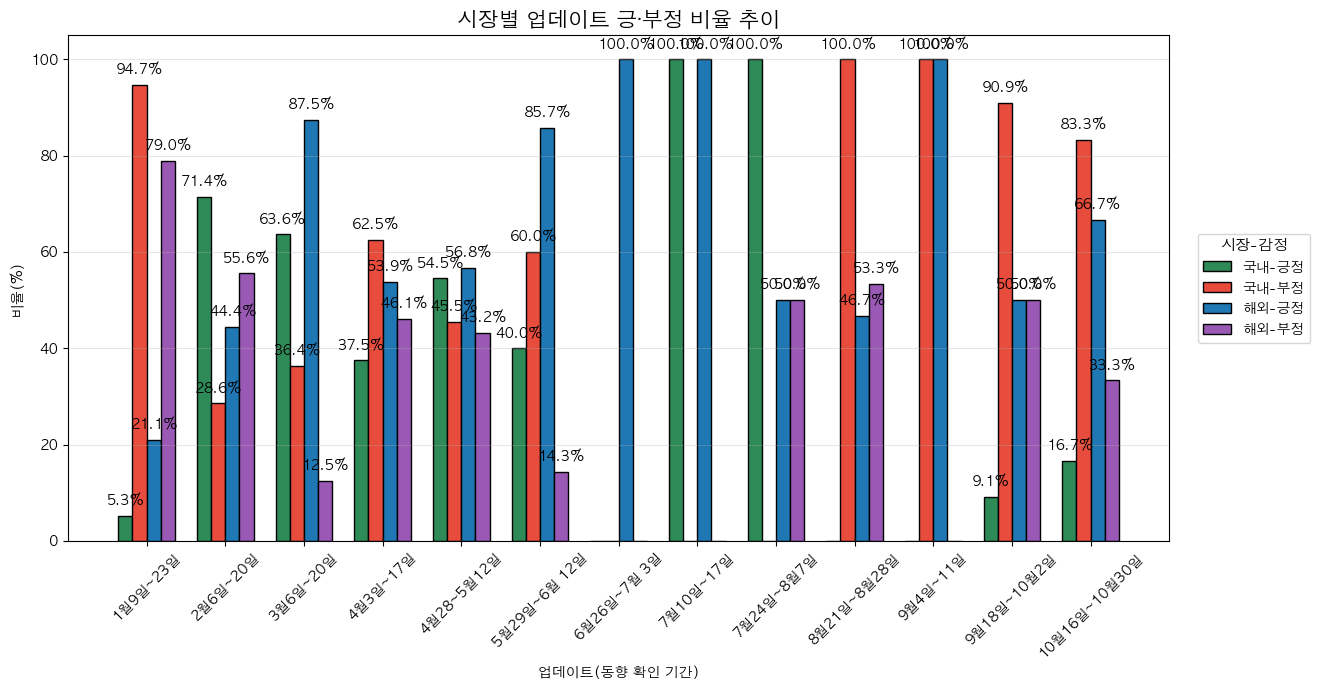

In [ ]:
def extract_month_day(text):
    match = re.search(r"(\d+)월(\d+)일", str(text))
    if match:
        return int(match.group(1)), int(match.group(2))
    return (0, 0)

market_df["월"], market_df["일"] = zip(*market_df["동향 확인 기간"].apply(extract_month_day))
market_df.sort_values(["월", "일"], inplace=True)
pivot_update = (
    market_df.groupby(["동향 확인 기간", "지역", "부정여부", "월", "일"])["비율(%)"]
    .mean()
    .reset_index()
    .pivot_table(
        index=["동향 확인 기간", "월", "일"],
        columns=["지역", "부정여부"],
        values="비율(%)"
    )
    .fillna(0)
    .sort_values(["월", "일"])
)

labels = [i[0] if isinstance(i, tuple) else i for i in pivot_update.index]

plt.figure(figsize=(14, 7))
bar_width = 0.18
x = np.arange(len(pivot_update.index))

colors = {
    ("국내", "긍정"): "#2E8B57",
    ("국내", "부정"): "#E74C3C",
    ("해외", "긍정"): "#1F77B4",
    ("해외", "부정"): "#9B59B6",
}

for i, col in enumerate(pivot_update.columns):
    plt.bar(
        x + (i - 1.5) * bar_width,
        pivot_update[col],
        width=bar_width,
        color=colors.get(col, "gray"),
        edgecolor="black",
        label=f"{col[0]}-{col[1]}"
    )

for i, col in enumerate(pivot_update.columns):
    for xi, yi in zip(x + (i - 1.5) * bar_width, pivot_update[col]):
        if yi > 0:
            plt.text(
                xi, yi + 1.5, f"{yi:.1f}%",
                ha="center", va="bottom",
                fontsize=10, weight="bold", color="black"
            )

plt.title("시장별 업데이트 긍·부정 비율 추이", fontsize=15, weight="bold")
plt.xlabel("업데이트(동향 확인 기간)")
plt.ylabel("비율(%)")
plt.xticks(x, labels, rotation=45)
plt.grid(axis="y", alpha=0.3)

plt.legend(
    title="시장-감정",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    fontsize=10,
    title_fontsize=11
)

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()


## 지정일 부정 반응 유형 비율

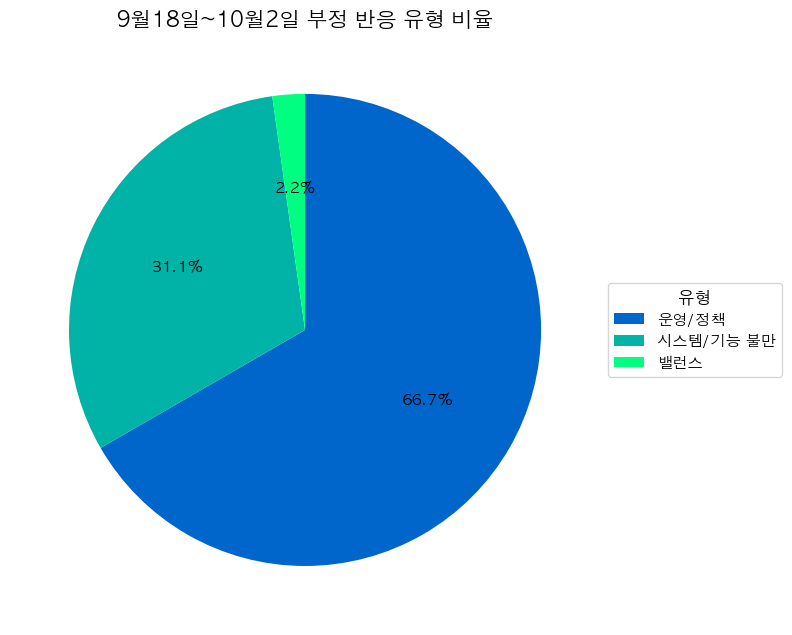

In [ ]:
neg_type_df = pd.read_excel(file_path, sheet_name="8_부정유형비율")
neg_type_df.dropna(inplace=True)
neg_type_df.sort_values("비율(%)", ascending=False, inplace=True)
colors = plt.cm.winter(np.linspace(0.4, 1, len(neg_type_df)))

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    neg_type_df["비율(%)"],
    labels=None,                   
    autopct="%1.1f%%",             
    startangle=90,
    colors=colors,
    counterclock=False,
    textprops={"fontsize": 11, "color": "black"}
)

plt.title("9월18일~10월2일 부정 반응 유형 비율", fontsize=15, weight="bold")
plt.legend(
    wedges,
    neg_type_df["유형"],
    title="유형",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=11,
    title_fontsize=12
)

plt.tight_layout()
plt.show()